# Preprocessing FireCCI5.1

For our analyses, we want to obtain the FireCCI5.1 burned_percentage (per pixel) in an iris cube on a 0.5° by 0.5° grid. Currently, the files (.nc) are stored in one file per month, which are stored in a directory per year. The individual files are on a 0.25° by 0.25° grid and contain i.a., burned_area (in m^2).

Here, we'll extract the 'burned_area' from the FireCCI5.1 files and merge the individual months and years (2001-2020) into one iris datacube file. Then, we'll regrid the cube, calculate the burned_fraction and save the resulting datacube. 

## 1. Loading packages

In [1]:
import os
import numpy as np
import iris
import cftime
import cf_units
import datetime
import matplotlib.pyplot as plt
import iris.quickplot as qplt

from Global_Variables import OBSERVATIONS_PATH, SUPPLEMENTARY_DATA_PATH

## 2. Load the FireCCI5.1 files

Select the location of the overarching FireCCI5.1 and FireCCILT11 directory

In [2]:
# Note that the 3 last months of 2019 were erroneous. 
# New versions have been uploaded (included in new-corrected sub-directory of 2019 folder) 
# but the files might need to be downloaded manually (https://data.ceda.ac.uk/neodc/esacci/fire/data/burned_area/MODIS/grid/v5.1/2019/new-corrected)
FIRECCI_PATH = os.path.join(OBSERVATIONS_PATH, 'FireCCI5.1', '')
FIRECCI_ORIG_PATH = os.path.join(FIRECCI_PATH, 'Original', '')

## 3. Load the 'burned_area' of all the months of each year into one iris CubeList

Let's walk the 'original' directory and its subdirectories (the years) and store the path to each .nc file (the months) in a list

In [3]:
FireCCI_files = [os.path.join(root,file) for root, _, files in os.walk(FIRECCI_ORIG_PATH) for file in files if file.endswith('.nc')]

Let's see how one month looks like

In [4]:
example = iris.load(os.path.join(FireCCI_files[0]))
example

[<iris 'Cube' of fraction of observed area / (1) (time: 1; latitude: 720; longitude: 1440)>,
<iris 'Cube' of vegetation class name / (1) (vegetation class number: 18; -- : 150)>,
<iris 'Cube' of standard error of the estimation of burned area / (m2) (time: 1; latitude: 720; longitude: 1440)>,
<iris 'Cube' of burned area in vegetation class / (m2) (time: 1; vegetation class number: 18; latitude: 720; longitude: 1440)>,
<iris 'Cube' of number of burn patches / (1) (time: 1; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fraction of burnable area / (1) (time: 1; latitude: 720; longitude: 1440)>,
<iris 'Cube' of burned_area / (m2) (time: 1; latitude: 720; longitude: 1440)>]

Okay, each month contains 7 cubes. Let's take a look at 'burned_area'. 

In [5]:
example[6]

<iris 'Cube' of burned_area / (m2) (time: 1; latitude: 720; longitude: 1440)>

There's a lot of metadata (great!). However, when combining different cubes, all metadata needs to be identical. Therefore, we need to get rid of a few unique fields such as 'id' and 'date_created', which prevent the concatenation of these cubes.

We'll create a callback that removes these attributes when loading the cubes.

In [6]:
def clean_callback(cube, field, filename):
    bad_atributes = ['time_coverage_start', 'time_coverage_end', 'tracking_id', 'history', 'id', 'date_created', 'time_coverage_duration', 'keywords_vocabulary', 'time_coverage_resolution']
    # Delete the problematic attributes
    for attribute in bad_atributes:
        del cube.attributes[attribute]

Let's load for each FireCCI5.1 month-file only the 'burned_area' and remove the problematic attributes. We'll store these cubes in a list.
Once we have our list of cubes, we can create a 'CubeList' and concatenate the cubes into one cube.

In [7]:
list_of_cubes = [iris.load_cube(file, iris.Constraint(cube_func=lambda x: x.var_name == 'burned_area'), callback=clean_callback) for file in FireCCI_files]
firecci_cube = iris.cube.CubeList(list_of_cubes).concatenate_cube()
firecci_cube

<iris 'Cube' of burned_area / (m2) (time: 240; latitude: 720; longitude: 1440)>

In [8]:
cs = iris.coord_systems.GeogCS(6371229)
firecci_cube.coords('latitude')[0].coord_system = cs
firecci_cube.coords('longitude')[0].coord_system = cs

## 4. Formating and regridding

We can convert the time units to be equal to our other datasets.

In [9]:
firecci_cube.coords('time')[0].units = cf_units.Unit('days since 1901-01-01', cf_units.CALENDAR_360_DAY)
firecci_cube.coords('time')[0].points = np.arange(240)*30+(360*100)
firecci_cube.coords('time')[0].bounds = None
firecci_cube.coords('time')[0].guess_bounds()

Now we can regrid the cube to the 0.5° by 0.5° grid.

Let's first load the ISIMIP landsea_mask, we'll use this to regrid to and to mask our data afterwards.
Alternatively, we could also interpolate our cube and then mask it, but since we need to use the landsea_mask file anyways, we might as well use it for both purposes.

In [10]:
landsea_mask = iris.load_cube(os.path.join(SUPPLEMENTARY_DATA_PATH, 'landseamask_no-ant.nc'))

landsea_mask.coords('latitude')[0].coord_system = cs
landsea_mask.coords('longitude')[0].coord_system = cs

if not landsea_mask.coords('latitude')[0].has_bounds():
    landsea_mask.coords('latitude')[0].guess_bounds()
if not landsea_mask.coords('longitude')[0].has_bounds():
    landsea_mask.coords('longitude')[0].guess_bounds()

Before regridding, we'll calculate the 'burned_percentage', this allows us to conserve the total burned area after regridding (the iris regridding/interpolating methods don't allow (yet) to conserve the total energy of the cube when regridding). However, we can achieve this by calculating the percentage first and regridding afterwards. 

In [11]:
firecci_cube_perc = firecci_cube/iris.analysis.cartography.area_weights(firecci_cube)*100
firecci_cube_perc = firecci_cube_perc.regrid(landsea_mask, iris.analysis.AreaWeighted(mdtol=0.5))

In [12]:
if not firecci_cube_perc.coords('latitude')[0].has_bounds():
    firecci_cube_perc.coords('latitude')[0].guess_bounds()
if not firecci_cube_perc.coords('longitude')[0].has_bounds():
    firecci_cube_perc.coords('longitude')[0].guess_bounds()

As a last step, let's mask the cube with the landsea_mask.

In [13]:
firecci_cube_perc = iris.util.mask_cube(firecci_cube_perc, np.logical_not(landsea_mask.data.data.squeeze()))

Let's update the metadata now

In [14]:
firecci_cube_perc.rename(f'Percentage of Area Burned')
firecci_cube_perc.units = '%'
firecci_cube_perc.attributes['spatial_resolution'] = '0.5 degrees'
firecci_cube_perc.attributes['geospatial_lon_resolution'] = 0.5
firecci_cube_perc.attributes['geospatial_lat_resolution'] = 0.5
firecci_cube_perc.attributes['title'] = f'FireCCI5.1 percentage of monthly burned area for 2001-2020'
firecci_cube_perc.coords('latitude')[0].long_name = 'Latitude'
firecci_cube_perc.coords('longitude')[0].long_name = 'Longitude'
firecci_cube_perc

<iris 'Cube' of Percentage of Area Burned / (%) (time: 240; latitude: 360; longitude: 720)>

Here's an example of August 2006

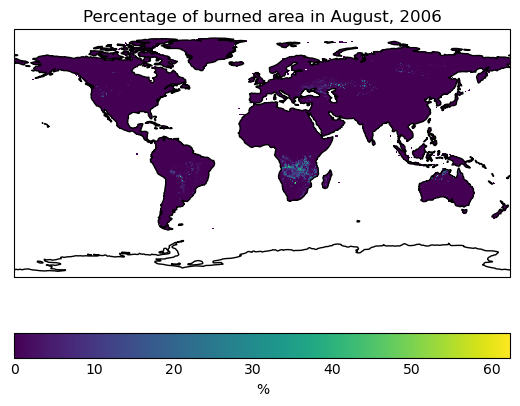

In [15]:
year, month = 2006, 8
fire_slice = firecci_cube_perc.extract(iris.Constraint(time=lambda cell: cell.point == iris.time.PartialDateTime(year=year, month=month, day=1)))
qplt.pcolormesh(fire_slice)
# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.title(f"Percentage of burned area in {datetime.datetime.strptime(str(month), '%m').strftime('%B')}, {year}")
plt.show()

Let's store our preprocessed cube in a single netcdf4 file.

In [16]:
iris.save(firecci_cube_perc, os.path.join(FIRECCI_PATH,'FireCCI5.1_Burned_Percentage.nc'))